***
# Cumulative Radiation events (CREs) analysis on a local scale
***
This notebook provides the analysis of Cumulative Radiation Events (CREs).

The data used in this notebook are from CMIP6 climate models. 
We are looking only at the grid box containing Zürich, Switzerland.

Copyright (c) 2023, ETH Zurich, Guillaume Senger

- Définition of CREs:

    $CRE(L)$ = lowest (highest) $L$-days time integrated mean SSR within one year

<br>

- Described using the **Generalized Extreme Value (GEV) Distribution**:

    - The probability density function (PDF) of the GEV distribution is given by:

        $$ f(x; μ, σ, ξ) = (1/σ) * exp{-[(z + ξ)^{(-1/ξ)}]} * [(z + ξ)^{(-1/ξ-1)}] $$ 
        where $z = (x - μ)/σ$, and x represents the random variable.



        Parameters : 
        
        
        -  $\xi$ (or c or k): The shape parameter that controls the tail behavior of the distribution. It determines whether the distribution has a heavy tail, light tail, or exponential tail.
            - When $\xi$ < 0, Fréchet distribution, which is suitable for modeling heavy-tailed distributions.
            - When $\xi$ = 0, Gumbel distribution, which is appropriate for modeling exponential-like distributions.
            - When $\xi$ > 0, Weibull distribution, which is useful for modeling bounded or light-tailed distributions.
        - $\mu$: The location parameter that shifts the distribution along the x-axis. It represents the mode or the center of the distribution.
        - $\sigma$: The scale parameter that controls the spread or variability of the distribution.

In [1]:
import my_functions
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy import stats
import matplotlib.colors as mcolors

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

matplotlib.rcParams.update({'font.size': 24})

---
## Load data and compute moving averages

In [2]:
variable_name  = 'rsds'
location       = 'Zurich'

output = pickle.load(open(f'Data/{variable_name}/{location}.pickle', 'rb')) # Load data created using the script Get_Data_Local.py

model_names = {
    'CanESM5':         {'color': 'tab:orange'},
    'CESM2':           {'color': 'g'},
    'CMCC-CM2-SR5':    {'color': 'c'},
    'CMCC-ESM2':       {'color': 'm'},
    'GFDL-CM4':        {'color': 'y'},
    'GFDL-ESM4':       {'color': 'b'},
    'NorESM2-LM':      {'color': 'tab:purple'},
    'NorESM2-MM':      {'color': 'tab:brown'},
    'TaiESM1':         {'color': 'tab:pink'}  ,
    # 'INM-CM4-8':       {'color': 'tab:gray'}  ,
    # 'INM-CM5-0':       {'color': 'tab:olive'} ,
    # 'IPSL-CM5A2-INCA': {'color': 'tab:cyan'}  ,
    # 'KIOST-ESM':       {'color': 'tab:olive'}
}

Ls = np.arange(4,22) # CRE lengths of interest

time_series_dict = {}

for model_name in output:

    rsds = output[model_name]
    
    time_series_dict[model_name] = {
        'rsds': rsds,
        'n_years': len(rsds) // 365,
        'moving_avg': {}  # Create a sub-dictionary for moving averages
    }

    # Compute the moving averages for all lengths 
    for L in Ls:
        
        time_series_dict[model_name]['moving_avg'][L] = pd.Series(rsds).rolling(window=L, center=True).mean()

## Statistics computation

We compute all the statistics required to analyse CREs.

- **GEV fit** : returns $\xi$ (shape parameter), $\mu$ (location parameter) and $\sigma$ (scale parameter)
- **Kolmogorov-Smirnov test** : Test the null hypothesis  $H_0$ : The empirical data follows a GEV distribution

    - KS Statistic (ks_statistic): Represents the magnitude of difference between the observed data and the expected distribution. A larger KS statistic indicates a greater difference between the observed data and the expected distribution.

    - P-value (p_value): The p-value represents the probability of obtaining a KS statistic as extreme as, or more extreme than, the observed value under the assumption that the null hypothesis is true:
    
        - If the p-value is small (below a predefined significance level, e.g., 0.05), it suggests that the observed data significantly deviates from the expected distribution, providing evidence to reject the null hypothesis in favor of an alternative hypothesis.

        - If the p-value is large, it indicates that the observed data is consistent with the expected distribution, and there is no significant evidence to reject the null hypothesis.

- **Probability theory concepts**:

    - Probability Density Function (PDF): Describes the probability distribution of a continuous random variable X. 

    - Cumulative Distribution Function (CDF): Gives the probability that a random variable X takes on a value less than or equal to a given value x and is defined as:
    $$F(x) = P(X ≤ x)$$

    - Probability of Exceedance: Refers to the probability of a random variable exceeding a certain threshold or critical value and is simply given by: 
    $$P(X > x) = 1 - F(x)$$

In [3]:
stats_dict = {}

for m, model_name in enumerate(model_names):

    stats_dict[model_name] = {}
    
    for L in Ls:

        print(f'\n\n{model_name = } and length {L = }\n')

        n_years       = time_series_dict[model_name]['n_years']
        time_series_L = time_series_dict[model_name]['moving_avg'][L].values

        reshaped_mean_values = time_series_L.reshape(n_years, 365)


        data = -np.nanmin(reshaped_mean_values, axis = 1) # Yearly minimums with switched signs to fit with the GEV distribution


        params = stats.genextreme.fit(data, scale = np.std(data)) # Compute GEV fit parameters with guess scale
        shape, loc, scale = params                                # Extract GEV fit parameters

        ks_statistic, p_value = stats.kstest(data, 'genextreme', args=params) # Kolmogorov-Smirnov Test on data to check quality of the fit
        # ks_statistic, p_value = stats.kstest((data-loc)/scale, 'norm') # Kolmogorov-Smirnov Test on data to check quality of the fit with a normal (Gaussian) distribution

        x_fit   = np.linspace(stats.genextreme.ppf(0.0001, *params), stats.genextreme.ppf(0.9999, *params), 100) 
        pdf_fit = stats.genextreme.pdf(x_fit, *params) # Compute pdf from fit               

        sorted_data = np.sort(data) # Sort the data to compute the CDF from the data
        cdf         = np.arange(1, len(sorted_data) + 1) / len(sorted_data) # Compute CDF from data
        cdf_fit     = stats.genextreme.cdf(x_fit, *params)                  # Compute CDF from GEV fit

        exceedance_prob     = 1 - cdf     # Compute probability of exceedance from data
        exceedance_prob_fit = 1 - cdf_fit # Compute probability of exceedance from GEV fit

        print(f"       Guessed Scale:        np.std(data) = {np.std(data):.2f} W/m^2")
        print(f"       Estimated Parameters: Shape        = {shape:.2f}")
        print(f"                             Location     = {-loc:.2f} W/m^2")
        print(f"                             Scale        = {scale:.2f} W/m^2")
        print(f"       KS Test Parameters:   KS Statistic = {ks_statistic:.2f} W/m^2")
        if p_value > 0.05:
            print(f"                             P-value      = {p_value:.2f} > 0.05 -> passed")
        else:
            print(f"                             P-value      = {p_value:.2f} < 0.05 -> FAILED")

        stats_dict[model_name][L] = {
            'data':                data,
            'x_fit':               x_fit,
            'pdf_fit':             pdf_fit,
            'sorted_data':         sorted_data,
            'cdf':                 cdf,
            'cdf_fit':             cdf_fit,
            'exceedance_prob':     exceedance_prob,
            'exceedance_prob_fit': exceedance_prob_fit,
            'Shape':               shape,
            'Location':            loc,
            'Scale':               scale,            
            'KS Statistic':        ks_statistic,
            'P-value':             p_value
        }



model_name = 'CanESM5' and length L = 4

       Guessed Scale:        np.std(data) = 4.29 W/m^2
       Estimated Parameters: Shape        = 0.36
                             Location     = 23.94 W/m^2
                             Scale        = 4.48 W/m^2
       KS Test Parameters:   KS Statistic = 0.02 W/m^2
                             P-value      = 0.59 > 0.05 -> passed


model_name = 'CanESM5' and length L = 5

       Guessed Scale:        np.std(data) = 4.77 W/m^2
       Estimated Parameters: Shape        = 0.38
                             Location     = 26.06 W/m^2
                             Scale        = 5.02 W/m^2
       KS Test Parameters:   KS Statistic = 0.03 W/m^2
                             P-value      = 0.49 > 0.05 -> passed


model_name = 'CanESM5' and length L = 6

       Guessed Scale:        np.std(data) = 5.09 W/m^2
       Estimated Parameters: Shape        = 0.35
                             Location     = 28.20 W/m^2
                             Scale     

       Guessed Scale:        np.std(data) = 5.53 W/m^2
       Estimated Parameters: Shape        = 0.28
                             Location     = 32.81 W/m^2
                             Scale        = 5.55 W/m^2
       KS Test Parameters:   KS Statistic = 0.02 W/m^2
                             P-value      = 0.96 > 0.05 -> passed


model_name = 'CanESM5' and length L = 10

       Guessed Scale:        np.std(data) = 5.56 W/m^2
       Estimated Parameters: Shape        = 0.28
                             Location     = 33.96 W/m^2
                             Scale        = 5.61 W/m^2
       KS Test Parameters:   KS Statistic = 0.02 W/m^2
                             P-value      = 0.93 > 0.05 -> passed


model_name = 'CanESM5' and length L = 11

       Guessed Scale:        np.std(data) = 5.52 W/m^2
       Estimated Parameters: Shape        = 0.27
                             Location     = 35.02 W/m^2
                             Scale        = 5.56 W/m^2
       KS Test Parameters

---
## KS test visualisation

This figure shows if the KS statitics test is passed (p-value > 5%) for all models considered and all the CREs lengths.

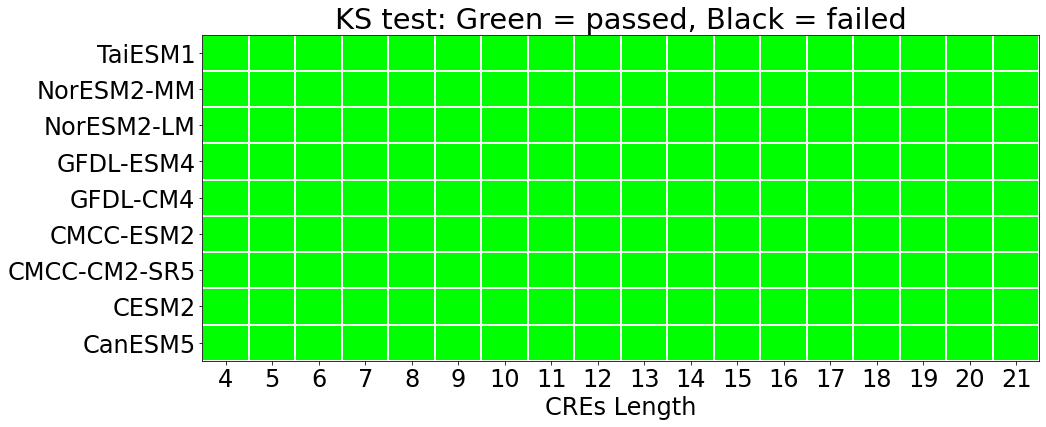

In [13]:
colors_binary = [(0, 0, 0), (0, 1, 0)]  # Black and Green
custom_cmap   = mcolors.LinearSegmentedColormap.from_list("custom_colormap", colors_binary, N=2)

array = np.zeros((len(model_names), len(Ls)))

for m, model_name in enumerate(model_names):
    for L_index, L in enumerate(Ls):
        
        pvalue = stats_dict[model_name][L]['P-value']

        if pvalue > 0.05:
            array[m, L_index] = 1
        else:
            print(f'P-value for {model_name} and length L = {L}: {pvalue:.3f} < 0.05 -> FAILED')


plt.figure(figsize=(15, 6))

plt.pcolormesh(Ls, list(model_names.keys()), array, cmap=custom_cmap, edgecolor="white", linewidth=0.1, vmin = 0, vmax = 1)
plt.title('KS test: Green = passed, Black = failed')
plt.xlabel("CREs Length")
plt.xticks(Ls)
plt.show()

---
## Graphical Interpretation of Results

L = 7   - GEV fit: $\xi$ = 0.31, $\mu$ = 31.00 W/m$^2$, $\sigma$ = 4.28 W/m$^2$ (KS test: p-value = 0.75, D = 0.03 W/m$^2$)
L = 14   - GEV fit: $\xi$ = 0.30, $\mu$ = 22.35 W/m$^2$, $\sigma$ = 3.96 W/m$^2$ (KS test: p-value = 0.27, D = 0.04 W/m$^2$)
L = 21   - GEV fit: $\xi$ = 0.29, $\mu$ = 28.14 W/m$^2$, $\sigma$ = 4.44 W/m$^2$ (KS test: p-value = 0.63, D = 0.03 W/m$^2$)


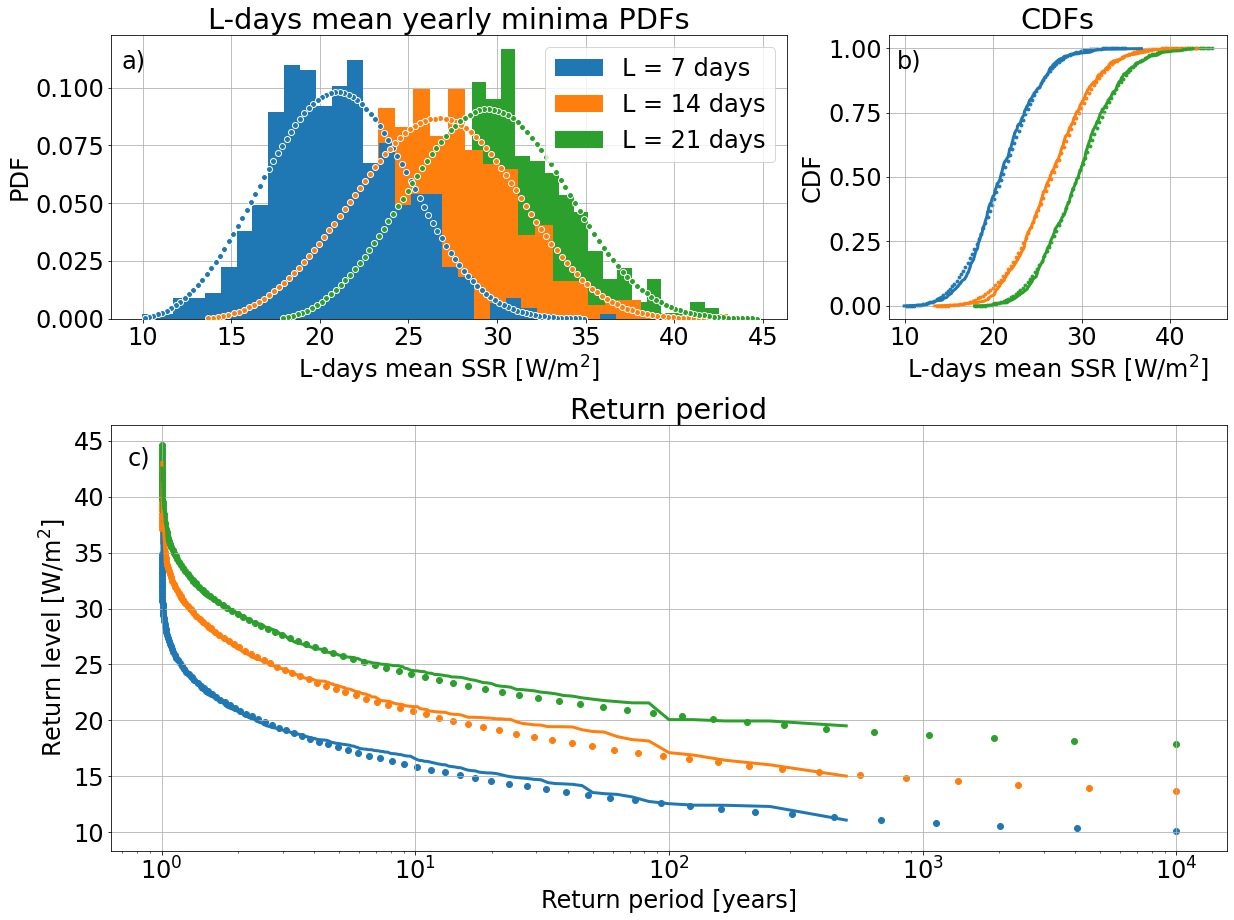

In [32]:
model_name = 'GFDL-ESM4'
Ls_to_plot = [7, 14, 21]

fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(2, 2, height_ratios=[1, 1.5], width_ratios = [2, 1], hspace = 0.3)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])


for L_index, L in enumerate(Ls_to_plot):

    print(f'L = {L}  ' + r' - GEV fit: $\xi$' + f' = {shape:.2f}, $\mu$ = {-loc:.2f} W/m$^2$, $\sigma$ = {scale:.2f} W/m$^2$ (KS test: p-value = {p_value:.2f}, D = {ks_statistic:.2f} W/m$^2$)')

    data, x_fit, pdf_fit, sorted_data, cdf, cdf_fit, exceedance_prob, exceedance_prob_fit, shape, loc, scale, ks_statistic, p_value = stats_dict[model_name][L].values()
    

    ax = ax1 # Plot the PDFs
    ax.set_title('L-days mean yearly minima PDFs')

    ax.hist(-data, bins=30, density=True, zorder= 4-L_index, label = f'{L = } days') # Note the minus sign to account for the fact that we switched the signs earlier
    ax.scatter(-x_fit, pdf_fit, edgecolor='white', zorder= 4)

    ax.set_xlabel(f'L-days mean SSR [W/m$^2$]')
    ax.set_ylabel("PDF")
    
    ax = ax2 # Plot the CDFs
    ax.set_title('CDFs')

    ax.plot(-sorted_data, 1-cdf, linewidth=3) # Note that for minimums, the CDF is actually 1-CDF
    ax.scatter(-x_fit, 1-cdf_fit, s = 8)

    ax.set_xlabel(f'L-days mean SSR [W/m$^2$]')
    ax.set_ylabel("CDF")
    

    ax = ax3 # Plot the Return periods
    ax.set_title("Return period")

    ax.plot(1/exceedance_prob, -sorted_data, linewidth=3)
    ax.scatter(1/exceedance_prob_fit, -x_fit)
    ticks = [1, 2, 5, 10, 20, 50,  100, 200, 500, 1000, 2000, 5000, 10000]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_xscale('log') 
    ax.set_ylabel("Return level [W/m$^2$]")
    ax.set_xlabel("Return period [years]")

    
for ax in [ax1, ax2, ax3]: ax.grid() 

ax1.legend()
ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.025, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')

plt.savefig(f'Figures/CREs_Analysis/CREs_{model_name}.png', bbox_inches='tight')

plt.show()

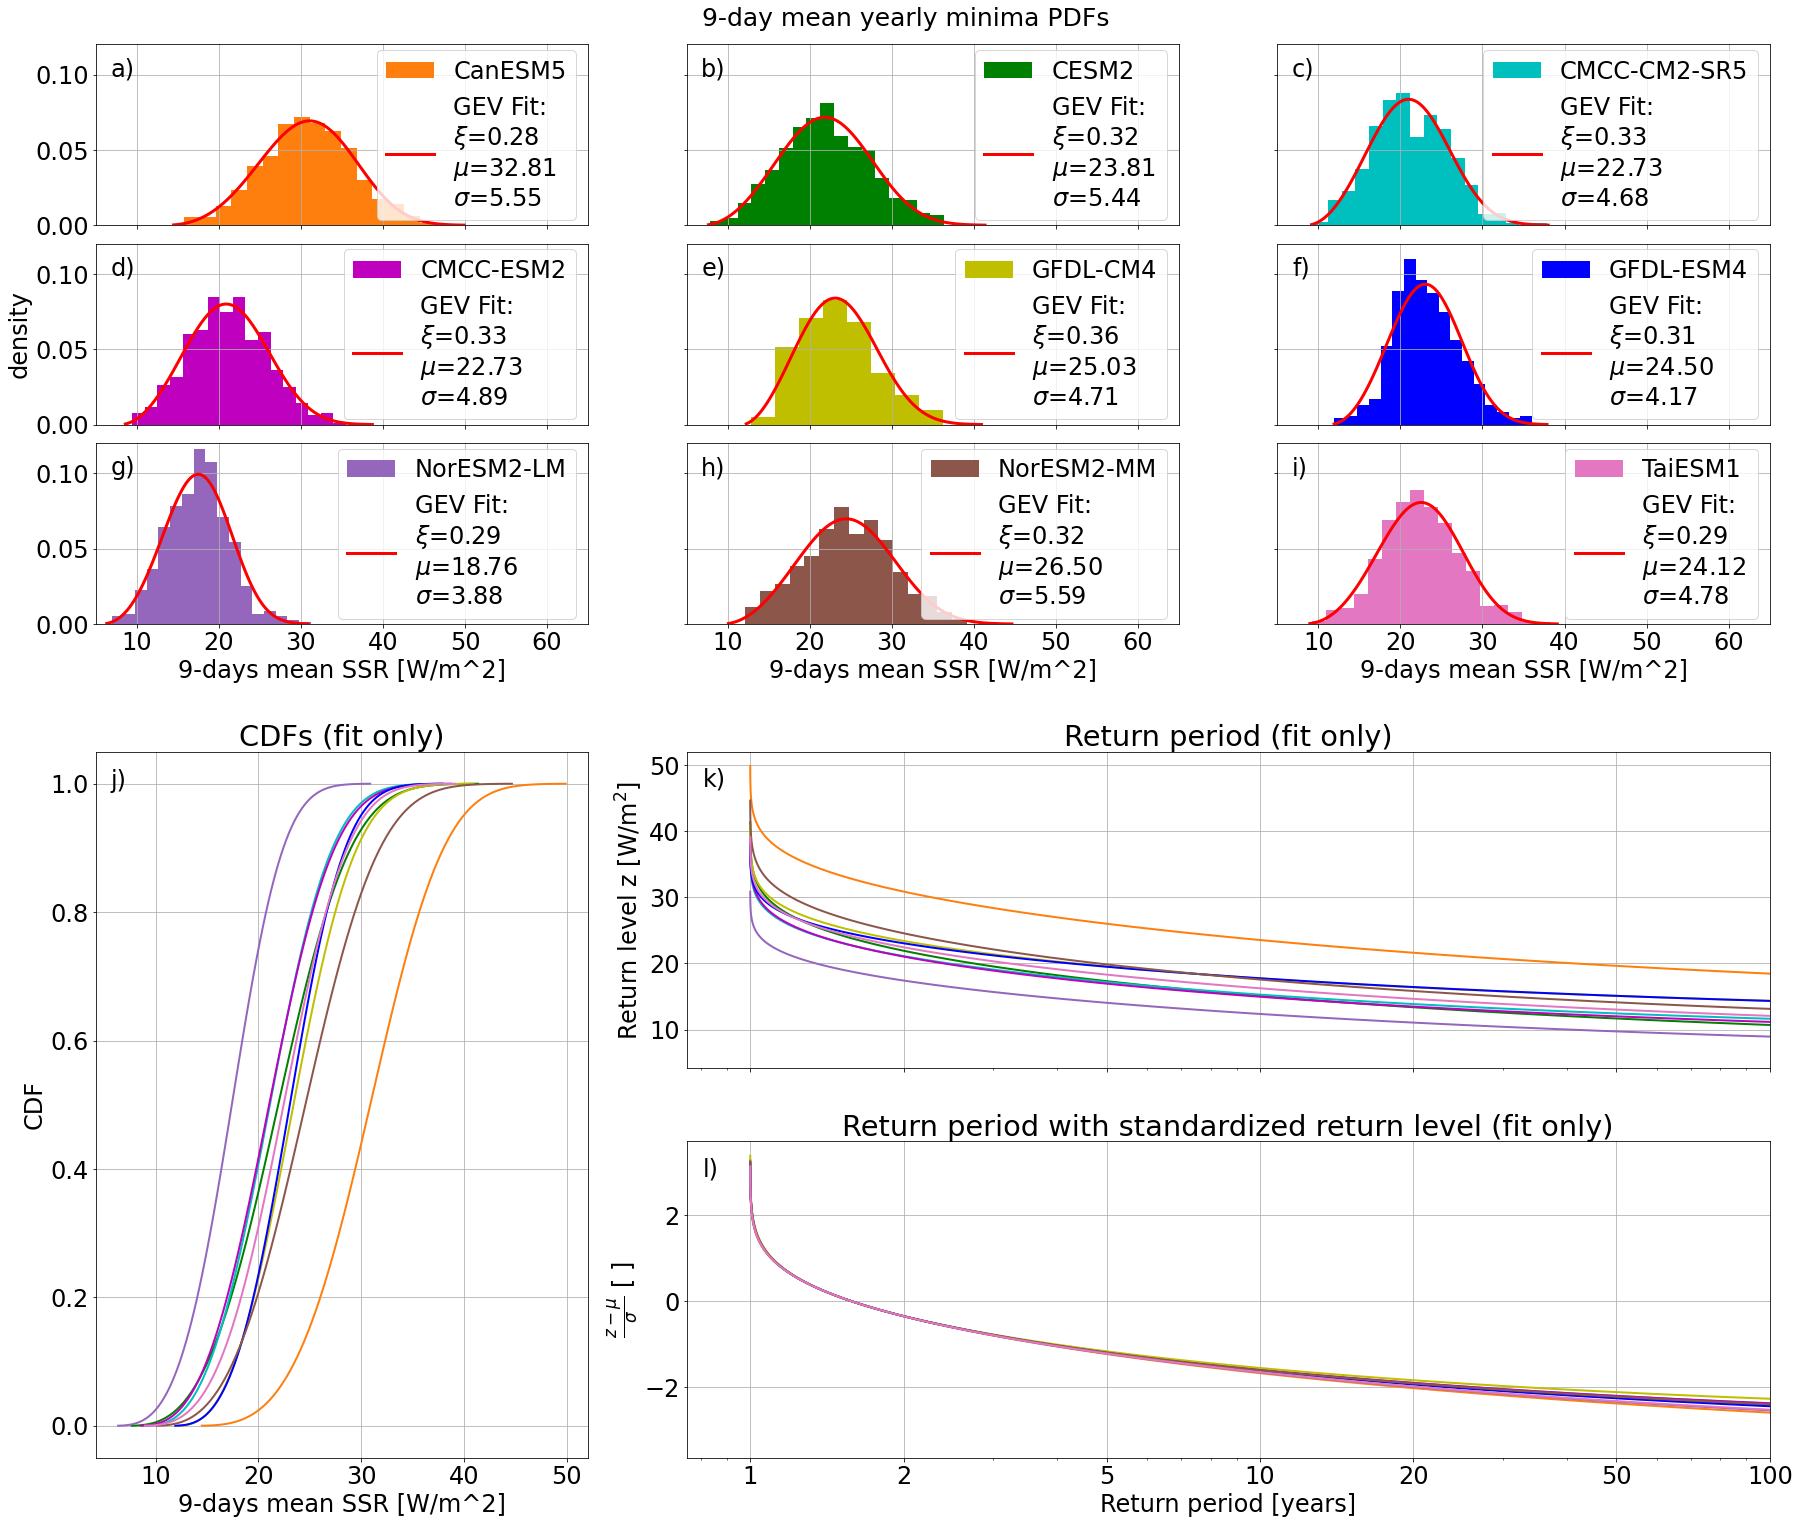

In [26]:
L        = 9                           # Choose the length of interest for the plot
nbins    = 17*np.ones(13, dtype='int') # Set the number of bins for the histograms
nbins[4] = 8                           # Less bins for the GFDL-CM4 model

fig = plt.figure(figsize = (30,26))
gs = fig.add_gridspec(7, 3, height_ratios=[1, 1, 1, 0.5, 1.75, 0.2, 1.75], wspace = 0.2, hspace = 0.1)

plt.suptitle(f'{L}-day mean yearly minima PDFs', fontsize = 25).set_y(0.9)

ax2 = fig.add_subplot(gs[4:,0]) # Plot for CDFs
ax3 = fig.add_subplot(gs[4,1:]) # Plot for return periods
ax4 = fig.add_subplot(gs[6,1:]) # Plot for standardised return periods

for m, model_name in enumerate(model_names):

    data, x_fit, pdf_fit, sorted_data, cdf, cdf_fit, exceedance_prob, exceedance_prob_fit, shape, loc, scale, ks_statistic, p_value = stats_dict[model_name][L].values()

    n_years = time_series_dict[model_name]['n_years']
    color   = model_names[model_name]['color']

    if m < 3:
        ax1 = fig.add_subplot(gs[0,m])
    else:
        if m < 6:
            ax1 = fig.add_subplot(gs[1,m-3])
        else:
            ax1 = fig.add_subplot(gs[2,m-6])

    ax = ax1


    ax.hist(-data, bins = nbins[m], density=True, color = color, label=model_name)

    if stats_dict[model_name][L]['P-value'] > 0.05:
        ax.plot(-x_fit, pdf_fit, label=f'GEV Fit: \n' +r'$\xi$' + f'={shape:.2f} \n$\mu$={-loc:.2f} \n$\sigma$={scale:.2f}', color = 'red', linewidth = 3)

    ax.legend(loc = 'right')
    ax.grid()

    if m == 3: ax.set_ylabel("density")
    
    if m not in [0,3,6]:
       
        ax.set_ylabel('')
        ax.set_yticklabels('')

    if m in [6,7,8]:
        ax.set_xlabel(f'{L}-days mean SSR [W/m^2]')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')
        
    ax.set_xlim(5, 65)
    ax.set_ylim(0,0.12)

    ax.text(0.03, 0.93, chr(ord('a') + m) + ')', transform=ax.transAxes, va='top')


    ax = ax2 # Plot the CDFs
    ax.set_title('CDFs (fit only)')

    # ax.plot(-sorted_data, 1-cdf, color = colors[m], label = model_name, linewidth = 2) # Empirical

    if stats_dict[model_name][L]['P-value'] > 0.05:
        ax.plot(-x_fit, 1-cdf_fit, label='GEV Fit', color = color, linewidth = 2)

    ax.set_xlabel(f'{L}-days mean SSR [W/m^2]')
    ax.set_ylabel("CDF")
    ax.grid()
    

    ax = ax3 # Plot the return periods
    ax.set_title("Return period (fit only)")

    # ax.plot(1/exceedance_prob, -sorted_data, color = colors[m], linewidth = 2) # Empirical

    if stats_dict[model_name][L]['P-value'] > 0.05:
        ax.plot(1/exceedance_prob_fit, -x_fit, label='GEV Fit', color = color, linewidth = 2)
    
    ax.set_xscale('log') 
    ticks = [1, 2, 5, 10, 20, 50,  100]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_ylabel("Return level z [W/m$^2$]")
    ax.grid()
    ax.set_xticklabels('')
    ax.set_xlim(0.75,100)

    ax = ax4 # Plot the standardised return periods
    ax.set_title("Return period with standardized return level (fit only)")


    ax.plot(1/exceedance_prob_fit, (-x_fit+loc)/scale, color = color, linewidth = 2)
    
    ax.set_xscale('log') 
    ticks = [1, 2, 5, 10, 20, 50,  100]
    ax.set_xticks(ticks)
    ax.set_xticklabels(ticks)
    ax.set_ylabel(r"$\frac{z - \mu}{\sigma}$ [ ]")
    ax.set_xlabel("Return period [years]")
    ax.grid()
    ax.set_xlim(0.75,100)
    

ax2.text(0.03, 0.975, 'j)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'k)', transform=ax3.transAxes, va='top')
ax4.text(0.015, 0.95, 'l)', transform=ax4.transAxes, va='top')


plt.savefig(f'Figures/CREs_Analysis/CREs_multi_model.png', bbox_inches='tight')

plt.show()

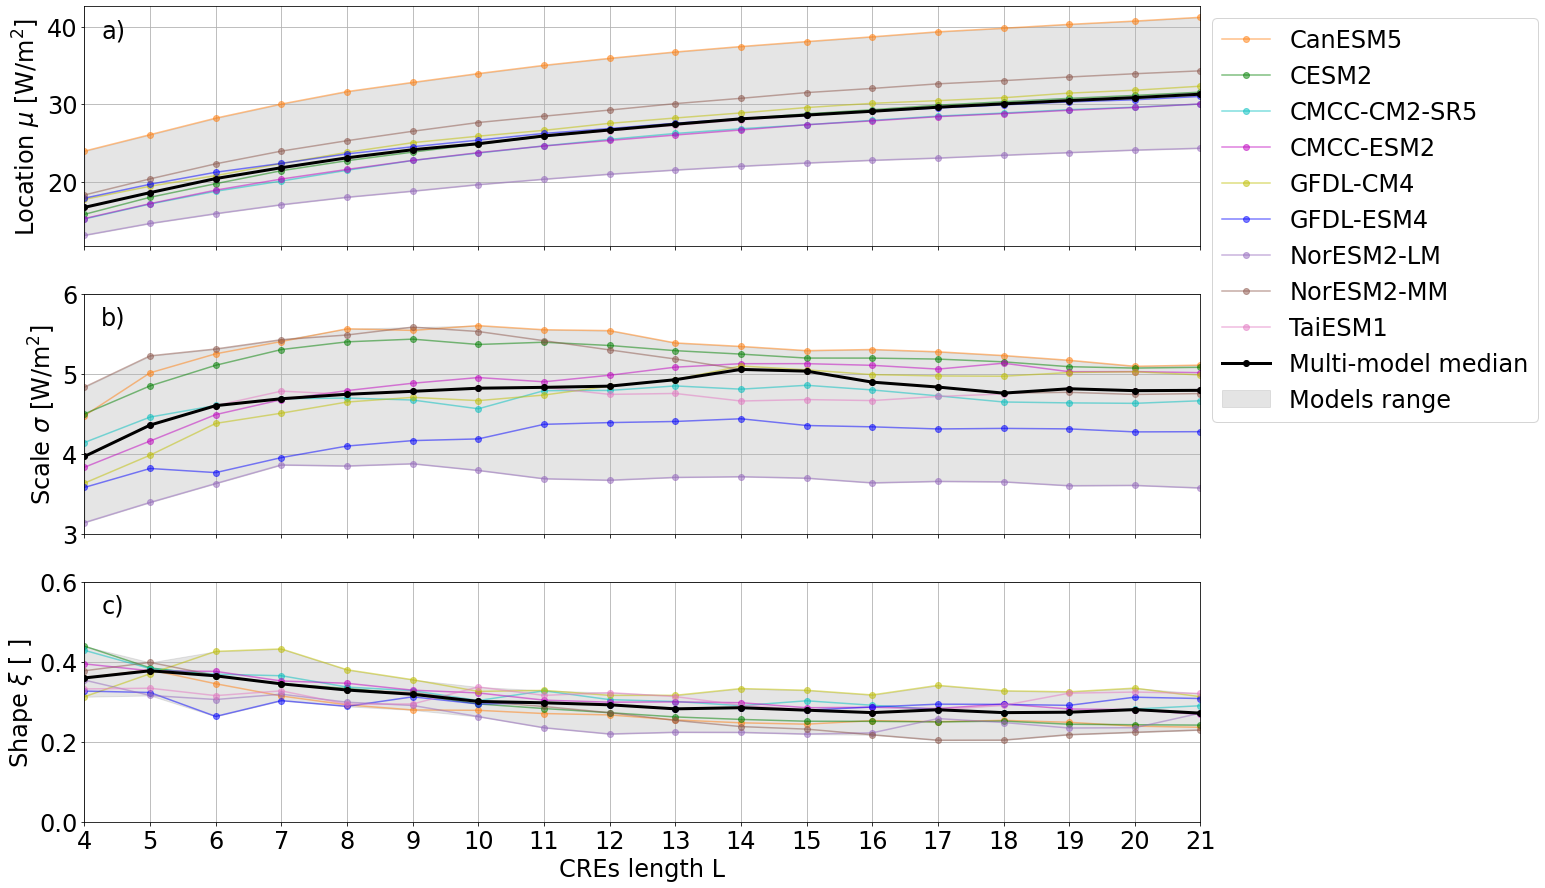

In [34]:
parameters = ['Location', 'Scale', 'Shape']

ylabels    = ['Location $\mu$ [W/m$^2$]', 'Scale $\sigma$ [W/m$^2$]', r'Shape $\xi$ [ ]']


all_params = np.empty((len(model_names), len(parameters), len(Ls)))

fig = plt.figure(figsize = (20,15))
gs  = fig.add_gridspec(3, 1)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])


axs = [ax1, ax2, ax3]

for m, model_name in enumerate(model_names):

    color = model_names[model_name]['color']

    for p_index, parameter in enumerate(parameters):

        ax  = axs[p_index]
        all = [values[parameter] for values in stats_dict[model_name].values()]

        if parameter == 'Location':
            all = [-values[parameter] for values in stats_dict[model_name].values()]


        all_params[m, p_index, :] = all

        ax.plot(Ls, all, marker = 'o', alpha = 0.5, color = color, label = model_name)
        ax.set_xticks(Ls)
        if p_index !=2:
            ax.set_xticklabels('')
        ax.set_ylabel(ylabels[p_index])


for p_index, parameter in enumerate(parameters):

    ax = axs[p_index]

    ax.plot(Ls, np.median(all_params[:,p_index,:], axis = 0), color = 'black', marker = 'o', linewidth = 3, label = 'Multi-model median')

    ax.fill_between(x=Ls, y1=np.min(all_params[:,p_index,:], axis = 0), y2=np.max(all_params[:,p_index,:], axis = 0), color =  'gray', label = 'Models range', alpha = .2)

    ax.set_xlim(np.min(Ls), np.max(Ls))


ax1.legend(bbox_to_anchor=(1, 1))


ax2.set_ylim(3,6)
ax3.set_ylim(0,.6)


ax.set_xlabel(f'CREs length L')



for ax in axs: ax.grid()

ax1.text(0.015, 0.95, 'a)', transform=ax1.transAxes, va='top')
ax2.text(0.015, 0.95, 'b)', transform=ax2.transAxes, va='top')
ax3.text(0.015, 0.95, 'c)', transform=ax3.transAxes, va='top')

plt.savefig(f'Figures/CREs_Analysis/CREs_multi_model_parameters.png', bbox_inches='tight')

plt.show()